In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

https://www.tensorflow.org/tutorials/images/classification

https://keras.io/examples/vision/image_classification_from_scratch/


# Setup

In [3]:
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow.keras as keras
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
import shutil


2024-04-11 15:46:02.596360: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-11 15:46:02.596521: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-11 15:46:02.738647: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
image_size = (96, 96)
batch_size = 128

train_dir = '/kaggle/input/histopathologic-cancer-detection/train'
test_dir = '/kaggle/input/histopathologic-cancer-detection/test'

# Load the Data

In [5]:
df_labels = pd.read_csv('/kaggle/input/histopathologic-cancer-detection/train_labels.csv')
df_samples = pd.read_csv('/kaggle/input/histopathologic-cancer-detection/sample_submission.csv')

df_labels.head()


,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [6]:
df_samples.head()

,id,label
0,0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5,0
1,95596b92e5066c5c52466c90b69ff089b39f2737,0
2,248e6738860e2ebcf6258cdc1f32f299e0c76914,0
3,2c35657e312966e9294eac6841726ff3a748febf,0
4,145782eb7caa1c516acbe2eda34d9a3f31c41fd6,0


# Processing Files

* Convert files from TIFF to JPG
* Construct the directory to:

    train_/0
    
    train_/1
    
* Move test image to:
    
    test_/0

In [7]:
os.makedirs('train_/0', exist_ok=True)  
os.makedirs('train_/1', exist_ok=True)  
os.makedirs('test_/0', exist_ok=True)  


In [8]:
for i in df_labels.index:
    filename = df_labels['id'][i] + '.tif'
    new_filename = df_labels['id'][i] + '.jpg'
    dest = os.path.join("train_", str(df_labels['label'][i]), new_filename)
    check_file = os.path.exists(dest)
    if not check_file:
        im = Image.open(os.path.join(train_dir, filename))
        im.thumbnail(im.size)
        im.save(dest, "JPEG", quality=100)


In [9]:
for i in df_samples.index:
    filename = df_samples['id'][i] + '.tif'
    new_filename = df_samples['id'][i] + '.jpg'
    dest = os.path.join("test_/0", new_filename)
    check_file = os.path.exists(dest)
    if not check_file:
        im = Image.open(os.path.join(test_dir, filename))
        im.thumbnail(im.size)
        im.save(dest, "JPEG", quality=100)


# Generate the dataset

In [11]:
train_ds, val_ds = keras.utils.image_dataset_from_directory(
    "train_",
    validation_split=0.2,
    subset="both",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)


Found 220025 files belonging to 2 classes.
Using 176020 files for training.
Using 44005 files for validation.


# Visualize the data

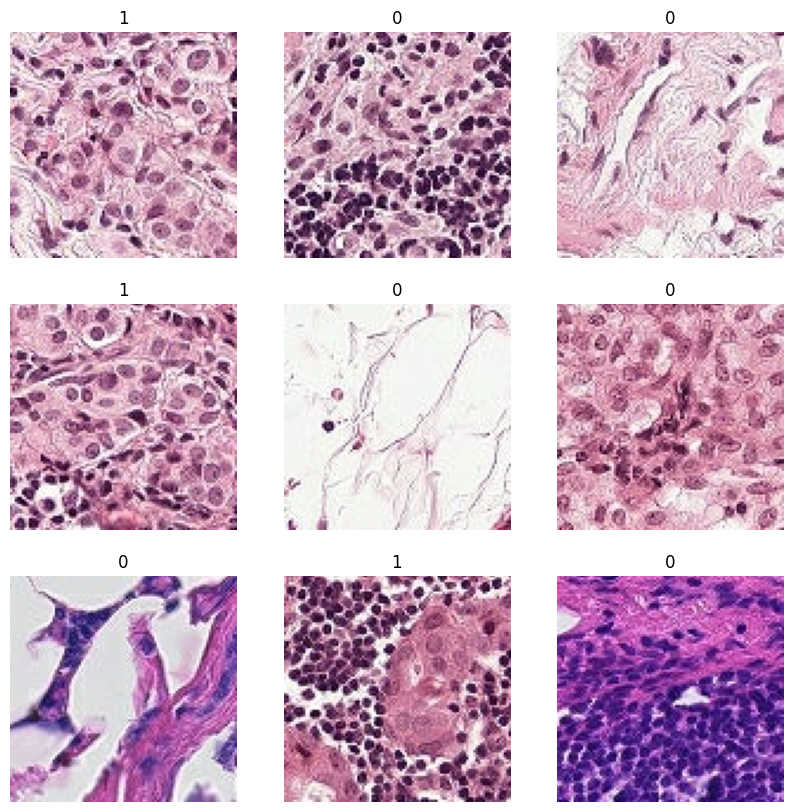

In [12]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(images[i]).astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")


# Using image data augmentation


In [13]:
data_augmentation_layers = [
    keras.layers.RandomFlip("horizontal"),
    keras.layers.RandomRotation(0.1),
]


def data_augmentation(images):
    for layer in data_augmentation_layers:
        images = layer(images)
    return images


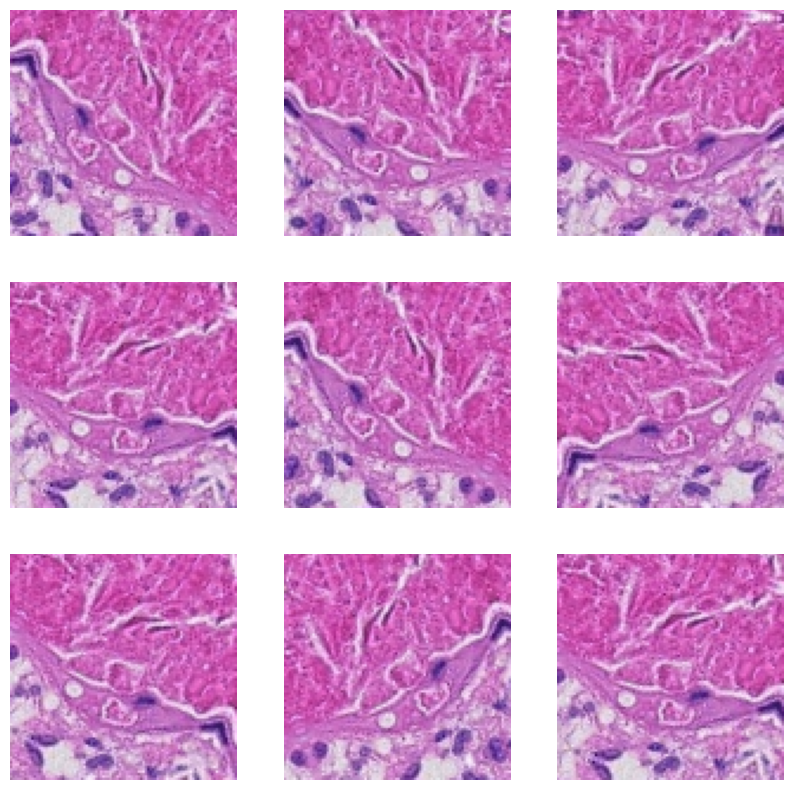

In [14]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(augmented_images[0]).astype("uint8"))
        plt.axis("off")


In [15]:
# Apply `data_augmentation` to the training images.
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf.data.AUTOTUNE,
)


# Configure the dataset for performance

In [16]:
# Prefetching samples in GPU memory helps maximize GPU utilization.
train_ds = train_ds.cache().shuffle(1000).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(tf.data.AUTOTUNE)


# Build a model

## Create a model

In [17]:
model = tf.keras.Sequential()
model.add(keras.Input(shape=image_size + (3,)))
model.add(keras.layers.Conv2D(16, (3,3), activation='relu'))
model.add(keras.layers.Conv2D(16, (3,3), activation='relu'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.MaxPool2D(pool_size=(3,3)))

# Batch normalization
model.add(keras.layers.Conv2D(32, (3,3), activation='relu'))
model.add(keras.layers.Conv2D(32, (3,3), activation='relu'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.MaxPool2D(pool_size=(3,3)))

# Batch normalization
model.add(keras.layers.Conv2D(64, (3,3), activation='relu'))
model.add(keras.layers.Conv2D(64, (3,3), activation='relu'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.MaxPool2D(pool_size=(3,3)))

# Convert to 1D vector
model.add(keras.layers.Flatten())

# Classification layers
model.add(keras.layers.Dense(64, activation='sigmoid'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(1, activation='sigmoid'))


## Compile the model 

In [18]:
model.compile(
    optimizer='adam',
    loss=keras.losses.BinaryCrossentropy(),
    metrics=['accuracy']
)


## Model summary

In [19]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 94, 94, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 92, 92, 16)     │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 92, 92, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 30, 30, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 26, 26, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 26, 26, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 6, 6, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 4, 4, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 4, 4, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 1, 1, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 76,753 (299.82 KB)

 Trainable params: 76,529 (298.94 KB)

 Non-trainable params: 224 (896.00 B)

## Train the model

In [26]:
epochs = 6
history = model.fit(
    train_ds,
    epochs=epochs,
    validation_data=val_ds,
)


Epoch 1/6
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 47s 34ms/step - accuracy: 0.9061 - loss: 0.2380 - val_accuracy: 0.8106 - val_loss: 0.4807
Epoch 2/6
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 46s 33ms/step - accuracy: 0.9094 - loss: 0.2273 - val_accuracy: 0.8257 - val_loss: 0.4685
Epoch 3/6
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 46s 34ms/step - accuracy: 0.9146 - loss: 0.2169 - val_accuracy: 0.7271 - val_loss: 0.9277
Epoch 4/6
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 46s 34ms/step - accuracy: 0.9174 - loss: 0.2118 - val_accuracy: 0.6752 - val_loss: 0.9140
Epoch 5/6
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 46s 34ms/step - accuracy: 0.9218 - loss: 0.1988 - val_accuracy: 0.8490 - val_loss: 0.4065
Epoch 6/6
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 46s 34ms/step - accuracy: 0.9254 - loss: 0.1907 - val_accuracy: 0.8412 - val_loss: 0.3835


# Visualize training results

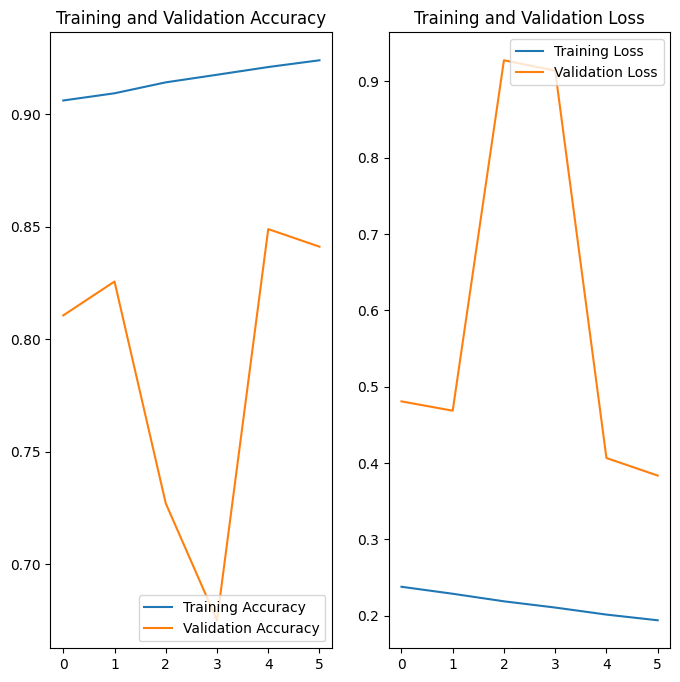

In [27]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


# Predict on new data

## Generate a test dataset

In [28]:
test_ds = keras.preprocessing.image_dataset_from_directory(
    'test_',
    batch_size=batch_size,
    image_size=image_size,
    shuffle=False
)


Found 57458 files belonging to 1 classes.


## Predict the data

In [29]:
predictions = model.predict(test_ds)
predictions = tf.where(predictions < 0.5,0, 1)
print(predictions.numpy())


449/449 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step
[[1]
 [1]
 [1]
 ...
 [0]
 [1]
 [0]]


## Submit the predictions

In [30]:
df_samples = df_samples.sort_values(by=['id'], ignore_index=True)
df_samples['label'] = predictions.numpy()
df_samples.head()


,id,label
0,00006537328c33e284c973d7b39d340809f7271b,1
1,0000ec92553fda4ce39889f9226ace43cae3364e,1
2,00024a6dee61f12f7856b0fc6be20bc7a48ba3d2,1
3,000253dfaa0be9d0d100283b22284ab2f6b643f6,0
4,000270442cc15af719583a8172c87cd2bd9c7746,0


In [31]:
df_samples.to_csv('submission.csv', index=False) 